# Clustering de activos con Momentum

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

En este notebook vamos a intentar aplicar las técnicas de clustering que hemos visto a los mercados financieros. Concretamente, vamos a explorar qué sucede si intentamos hacer clustering exclusivamente con los valores de retorno logarítmico frente a hacer clustering utilizando otro tipo de indicadores, como el Momentum.

$$Momentum = {C_t \over C_{t-N}},$$

$$log(Momentum) = log(C_t) - log(C_{t-N}) = \sum_{i=0}^N r_{t-i},$$

donde $r_t = log(C_t) - log(C_{t-1})$.

Descargamos los datos de los 500 activos del SP500 por si los necesitamos.

In [ ]:
comp = pd.read_csv("https://raw.githubusercontent.com/christianolivamoya/MIAX13-ML/refs/heads/main/dataset/data_comp_SP500.csv")
comp.index = pd.to_datetime(comp["Date"])
comp = comp.drop(columns="Date")
comp

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,22.010019,2.527393,NaN,NaN,15.535000,7.495556,26.393572,39.919998,21.267511,20.790808,...,71.817345,14.521288,55.838711,12.267728,40.008057,NaN,14.978962,67.402054,34.880001,NaN
2007-01-04,22.080608,2.583492,NaN,NaN,15.830029,7.492222,26.988495,40.820000,21.636642,20.674070,...,71.995499,14.375073,55.861889,12.278193,39.257668,NaN,14.938252,68.905663,34.680000,NaN
2007-01-05,21.875275,2.565094,NaN,NaN,15.830029,7.418889,26.611225,40.619999,21.390556,20.641642,...,71.247040,14.329007,56.192532,12.032106,39.538406,NaN,14.808467,68.861954,34.330002,NaN
2007-01-08,21.798277,2.577761,NaN,NaN,15.887125,7.462222,26.995731,40.450001,21.558935,20.745407,...,70.765923,14.455191,57.253983,12.032106,39.219875,NaN,14.772831,68.416115,34.400002,NaN
2007-01-09,21.823936,2.791895,NaN,NaN,16.026716,7.392222,26.930435,39.630001,21.526560,20.239580,...,70.035217,14.381088,57.480175,12.026868,38.917580,NaN,14.828820,68.459839,34.340000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14,144.250000,231.300003,194.099991,134.789993,116.699997,111.089996,364.600006,509.649994,236.429993,57.910000,...,292.649994,32.590000,103.949997,63.020000,124.080002,137.240005,134.649994,104.830002,377.679993,192.194565
2024-10-15,144.580002,233.850006,191.860001,133.270004,116.050003,108.059998,368.660004,508.029999,225.869995,57.669998,...,291.140015,33.049999,99.220001,63.430000,120.349998,136.679993,133.220001,104.599998,375.299988,191.935181
2024-10-16,139.110001,231.779999,190.460007,135.149994,117.820000,107.470001,372.260010,502.540009,227.490005,58.290001,...,291.299988,33.450001,100.239998,64.010002,120.660004,137.460007,133.350006,105.459999,375.500000,193.980331


In [ ]:
idx = pd.read_csv("https://raw.githubusercontent.com/christianolivamoya/MIAX13-ML/refs/heads/main/dataset/data_idx_SP500.csv")
idx.index = pd.to_datetime(idx["Date"])
idx = idx.drop(columns="Date")
idx

,IDX
Date,
2007-01-03,100.900597
2007-01-04,101.114723
2007-01-05,100.308189
2007-01-08,100.772102
2007-01-09,100.686485
...,...
2024-10-14,584.320007
2024-10-15,579.780029
2024-10-16,582.299988


In [ ]:
precios = pd.concat((comp, idx), axis=1)
precios

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,IDX
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,22.010019,2.527393,NaN,NaN,15.535000,7.495556,26.393572,39.919998,21.267511,20.790808,...,14.521288,55.838711,12.267728,40.008057,NaN,14.978962,67.402054,34.880001,NaN,100.900597
2007-01-04,22.080608,2.583492,NaN,NaN,15.830029,7.492222,26.988495,40.820000,21.636642,20.674070,...,14.375073,55.861889,12.278193,39.257668,NaN,14.938252,68.905663,34.680000,NaN,101.114723
2007-01-05,21.875275,2.565094,NaN,NaN,15.830029,7.418889,26.611225,40.619999,21.390556,20.641642,...,14.329007,56.192532,12.032106,39.538406,NaN,14.808467,68.861954,34.330002,NaN,100.308189
2007-01-08,21.798277,2.577761,NaN,NaN,15.887125,7.462222,26.995731,40.450001,21.558935,20.745407,...,14.455191,57.253983,12.032106,39.219875,NaN,14.772831,68.416115,34.400002,NaN,100.772102
2007-01-09,21.823936,2.791895,NaN,NaN,16.026716,7.392222,26.930435,39.630001,21.526560,20.239580,...,14.381088,57.480175,12.026868,38.917580,NaN,14.828820,68.459839,34.340000,NaN,100.686485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14,144.250000,231.300003,194.099991,134.789993,116.699997,111.089996,364.600006,509.649994,236.429993,57.910000,...,32.590000,103.949997,63.020000,124.080002,137.240005,134.649994,104.830002,377.679993,192.194565,584.320007
2024-10-15,144.580002,233.850006,191.860001,133.270004,116.050003,108.059998,368.660004,508.029999,225.869995,57.669998,...,33.049999,99.220001,63.430000,120.349998,136.679993,133.220001,104.599998,375.299988,191.935181,579.780029
2024-10-16,139.110001,231.779999,190.460007,135.149994,117.820000,107.470001,372.260010,502.540009,227.490005,58.290001,...,33.450001,100.239998,64.010002,120.660004,137.460007,133.350006,105.459999,375.500000,193.980331,582.299988


Seleccionamos un subconjunto de activos para trabajar con ellos.

In [ ]:
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "JPM", "NVDA", "V", "UNH", "PG", "HD", "MA", "BAC", "ADBE", "NFLX", "META", "TSLA", "JNJ", "WMT", "IDX"]
YEAR_START = 2013
START_DATE = str(YEAR_START)+"-01-01"
data = precios.loc[START_DATE:, TICKERS]
data.head()

,AAPL,MSFT,AMZN,GOOGL,JPM,NVDA,V,UNH,PG,HD,MA,BAC,ADBE,NFLX,META,TSLA,JNJ,WMT,IDX
Date,,,,,,,,,,,,,,,,,,,
2013-01-02,16.705696,22.451811,12.8655,18.054642,32.313251,0.293535,35.736618,45.537476,49.248260,48.451305,47.532612,9.721240,38.340000,13.144286,27.915949,2.357333,51.169823,18.031240,118.375748
2013-01-03,16.494837,22.151054,12.9240,18.065126,32.248127,0.293766,35.764214,43.408394,48.935970,48.313915,47.600609,9.664675,37.750000,13.798571,27.686640,2.318000,51.097584,17.916658,118.108307
2013-01-04,16.035381,21.736477,12.9575,18.422102,32.819736,0.303458,36.056324,43.491879,49.035332,48.222336,47.598751,9.785885,38.130001,13.711429,28.673668,2.293333,51.682663,17.984371,118.626968
2013-01-07,15.941056,21.695833,13.4230,18.341721,32.855904,0.294689,36.313900,43.491879,48.701767,47.962814,48.423634,9.769724,37.939999,14.171429,29.331684,2.289333,51.574326,17.812496,118.302803
2013-01-08,15.983959,21.582026,13.3190,18.305525,32.921024,0.288227,36.651997,42.915768,48.623688,48.252853,48.264263,9.680837,38.139999,13.880000,28.972765,2.245333,51.581532,17.861977,117.962463


Calculamos los retornos a partir de los precios.

In [ ]:
retornos = np.log(data).diff().dropna()
retornos.head()

,AAPL,MSFT,AMZN,GOOGL,JPM,NVDA,V,UNH,PG,HD,MA,BAC,ADBE,NFLX,META,TSLA,JNJ,WMT,IDX
Date,,,,,,,,,,,,,,,,,,,
2013-01-03,-0.012702,-0.013486,0.004537,0.000581,-0.002017,0.000786,0.000772,-0.047883,-0.006361,-0.002840,0.001430,-0.005836,-0.015508,0.048578,-0.008248,-0.016826,-0.001413,-0.006375,-0.002262
2013-01-04,-0.028250,-0.018893,0.002589,0.019568,0.017570,0.032460,0.008134,0.001921,0.002028,-0.001897,-0.000039,0.012464,0.010016,-0.006335,0.035029,-0.010699,0.011385,0.003772,0.004382
2013-01-07,-0.005900,-0.001872,0.035295,-0.004373,0.001101,-0.029323,0.007118,0.000000,-0.006826,-0.005396,0.017181,-0.001653,-0.004995,0.032998,0.022689,-0.001746,-0.002098,-0.009603,-0.002736
2013-01-08,0.002688,-0.005259,-0.007778,-0.001975,0.001980,-0.022170,0.009267,-0.013335,-0.001604,0.006029,-0.003297,-0.009140,0.005258,-0.020779,-0.012312,-0.019407,0.000140,0.002774,-0.002881
2013-01-09,-0.015752,0.005634,-0.000113,0.006551,-0.000660,-0.022673,0.015133,0.018696,0.005386,-0.000791,0.027748,-0.046997,0.013542,-0.012949,0.051311,-0.001188,0.004471,-0.000292,0.002538


## Clustering de un único activo

Vamos a definir qué valores de Momentum queremos, además del retorno logarítmico (que podría interpretarse como `Momentum@1`):

In [ ]:
TICKER = "IDX" # SP500
momentum_values = [5, 10, 20, 30, 40, 50]
lista_atributos = ["momentum@"+str(m) for m in momentum_values]

In [ ]:
atributos = pd.DataFrame()
for m in momentum_values:
  atributos = pd.concat((atributos, retornos[TICKER].rolling(m).sum()), axis=1)

atributos.columns = lista_atributos
atributos = atributos.dropna()
atributos

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50
2013-03-15 00:00:00,0.006943,0.028599,0.027417,0.044570,0.062431,0.069186
2013-03-18 00:00:00,-0.002379,0.017755,0.023066,0.028802,0.050457,0.065914
2013-03-19 00:00:00,-0.002459,0.006510,0.013273,0.037780,0.045904,0.059206
2013-03-20 00:00:00,0.003090,0.012111,0.032776,0.034695,0.047487,0.068904
2013-03-21 00:00:00,-0.010799,0.001721,0.030294,0.025387,0.037299,0.063205
...,...,...,...,...,...,...
2024-10-14 00:00:00,0.028680,0.018238,0.040516,0.039025,0.055787,0.095178
2024-10-15 00:00:00,0.011466,0.019436,0.032307,0.052018,0.038471,0.116934
2024-10-16 00:00:00,0.008901,0.023351,0.039615,0.058404,0.044436,0.112093
2024-10-17 00:00:00,0.010738,0.025267,0.022780,0.060925,0.041091,0.118886


No olvidemos normalizar los datos, ya que diferentes momentums se pueden mover en rangos de valores diferentes.

In [ ]:
means_train = atributos.mean()
stds_train = atributos.std()
dataset = (atributos - means_train) / stds_train

Veamos qué aspecto tiene realmente nuestro dataset.

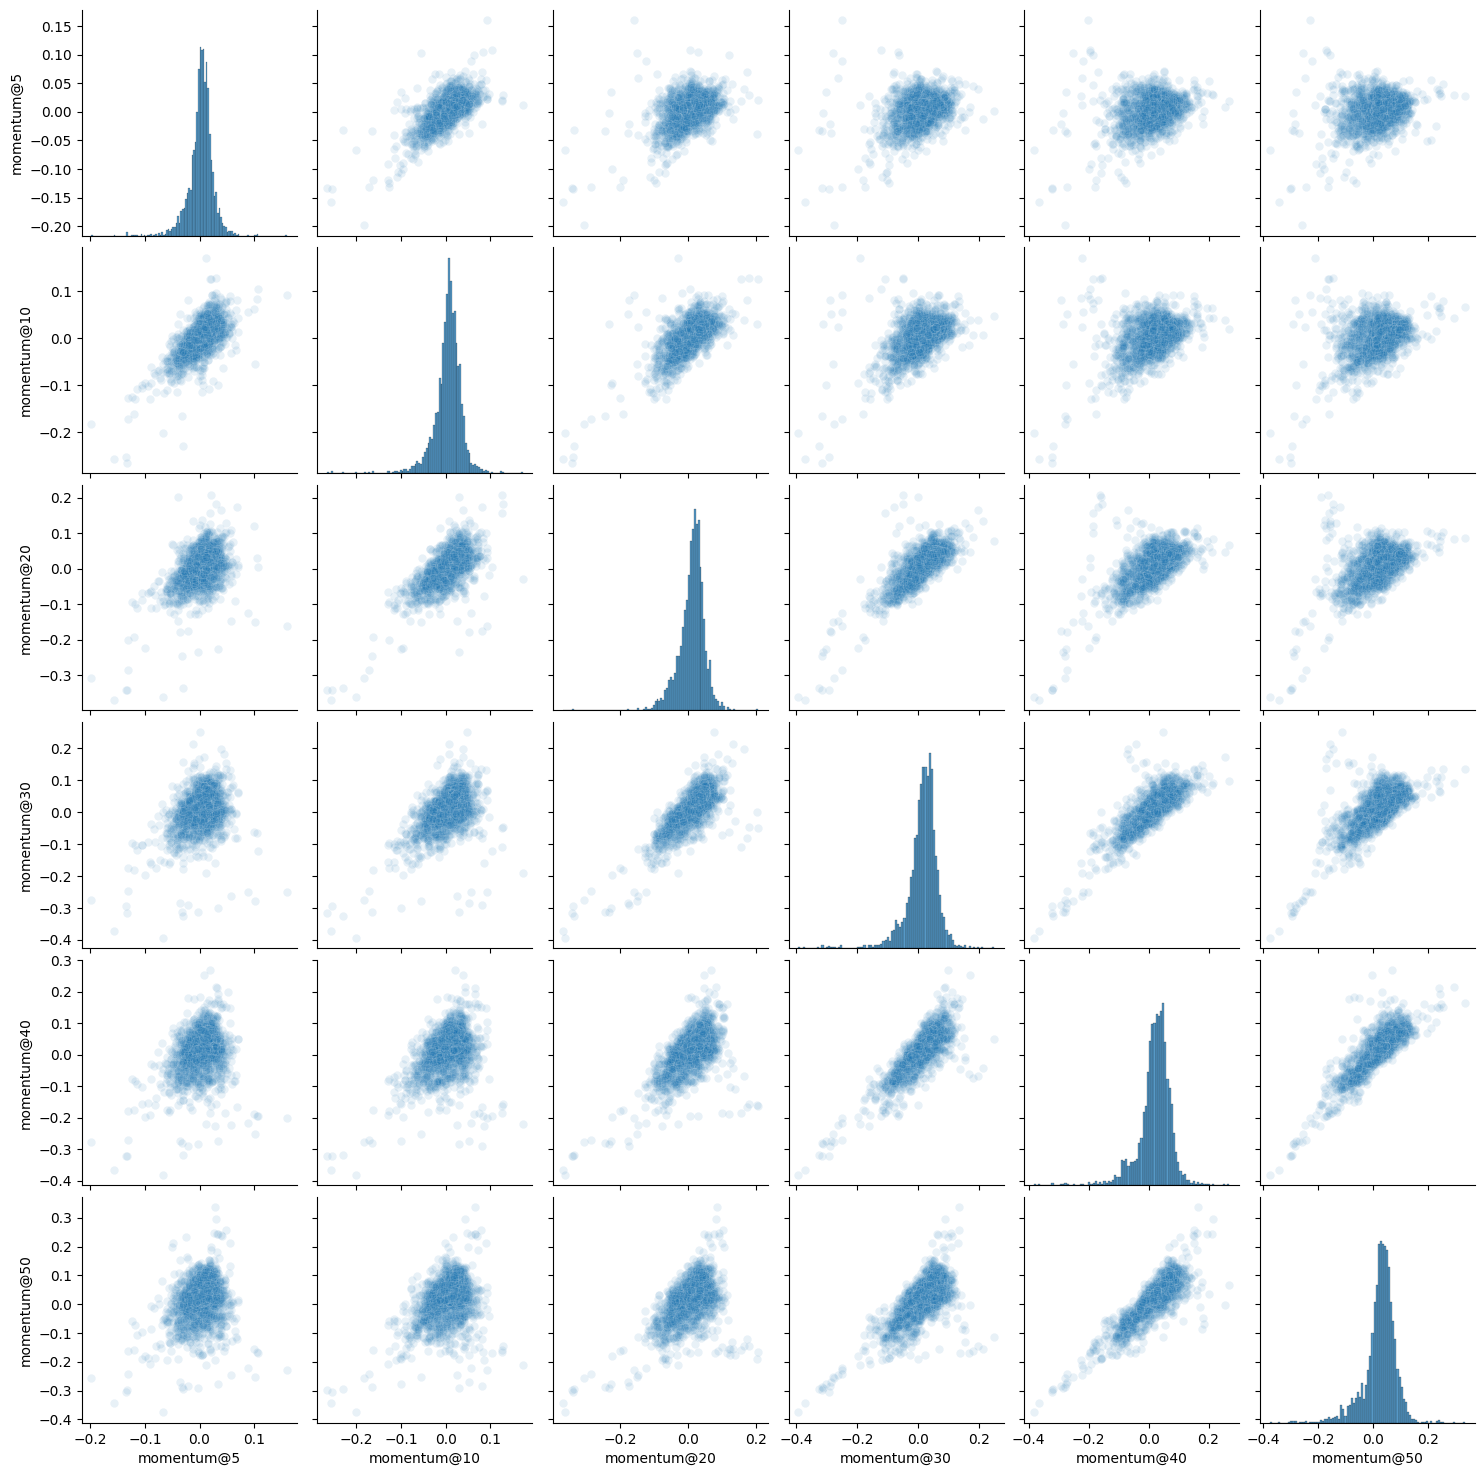

In [ ]:
sns.pairplot(atributos, kind='scatter', plot_kws={'alpha':0.1}) # Pintamos los datos sin normalizar
plt.show()

Con estos datos, vamos a intentar utilizar KMeans para clusterizar. Empecemos con un clustering de `K=2`.

In [ ]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset) # Hacemos clustering con los datos normalizados!!
clusters = kmeans.predict(dataset)

Visualicemos ahora los dos clusters, a ver qué aspecto tienen los datos según el cluster al que pertenezca. Usemos un boxplot para ver mediana, cuartiles y outliers.

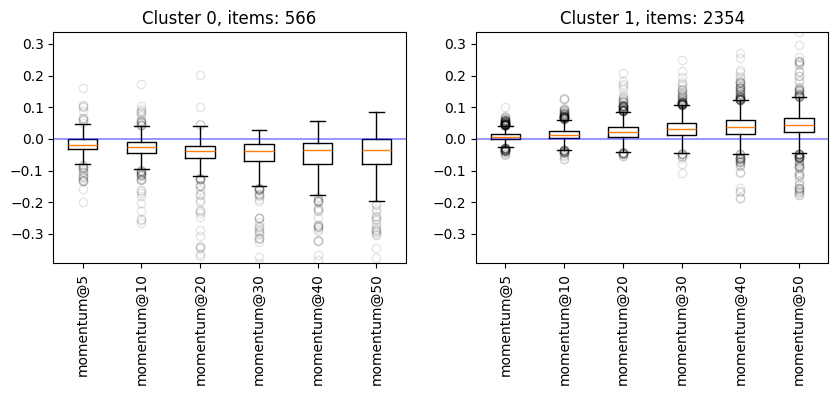

In [ ]:
plt.figure(figsize=(10, 3))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = atributos[indices]
    plt.subplot(1, 2, c+1)
    plt.boxplot(datos, flierprops={"alpha":0.1})
    plt.ylim(atributos.min().min(), atributos.max().max())
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.axhline(0.0, color="blue", alpha=0.4)
    plt.xticks(range(1, dataset.shape[1]+1), lista_atributos, rotation=90)
plt.show()

**Pregunta**: ¿Qué conclusiones podemos sacar de este resultado?

Intentemos visualizar los datos por cluster en el espacio de datos en el que estamos.

In [ ]:
df_clusters = pd.concat([atributos, pd.Series(clusters, name='cluster', index=dataset.index)], axis=1)
df_clusters.sample(5)

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50,cluster
2023-06-30 00:00:00,0.022979,0.005243,0.053331,0.069077,0.086593,0.071705,1
2022-08-12 00:00:00,0.032433,0.036019,0.103437,0.124110,0.123265,0.046172,1
2021-12-13 00:00:00,0.016815,0.004231,-0.001499,0.015813,0.045381,0.071811,1
2014-10-29 00:00:00,0.027740,0.060767,0.019162,-0.008574,-0.007328,0.003251,1
2018-06-05 00:00:00,0.022349,0.006308,0.030186,0.031498,0.052614,0.063981,1


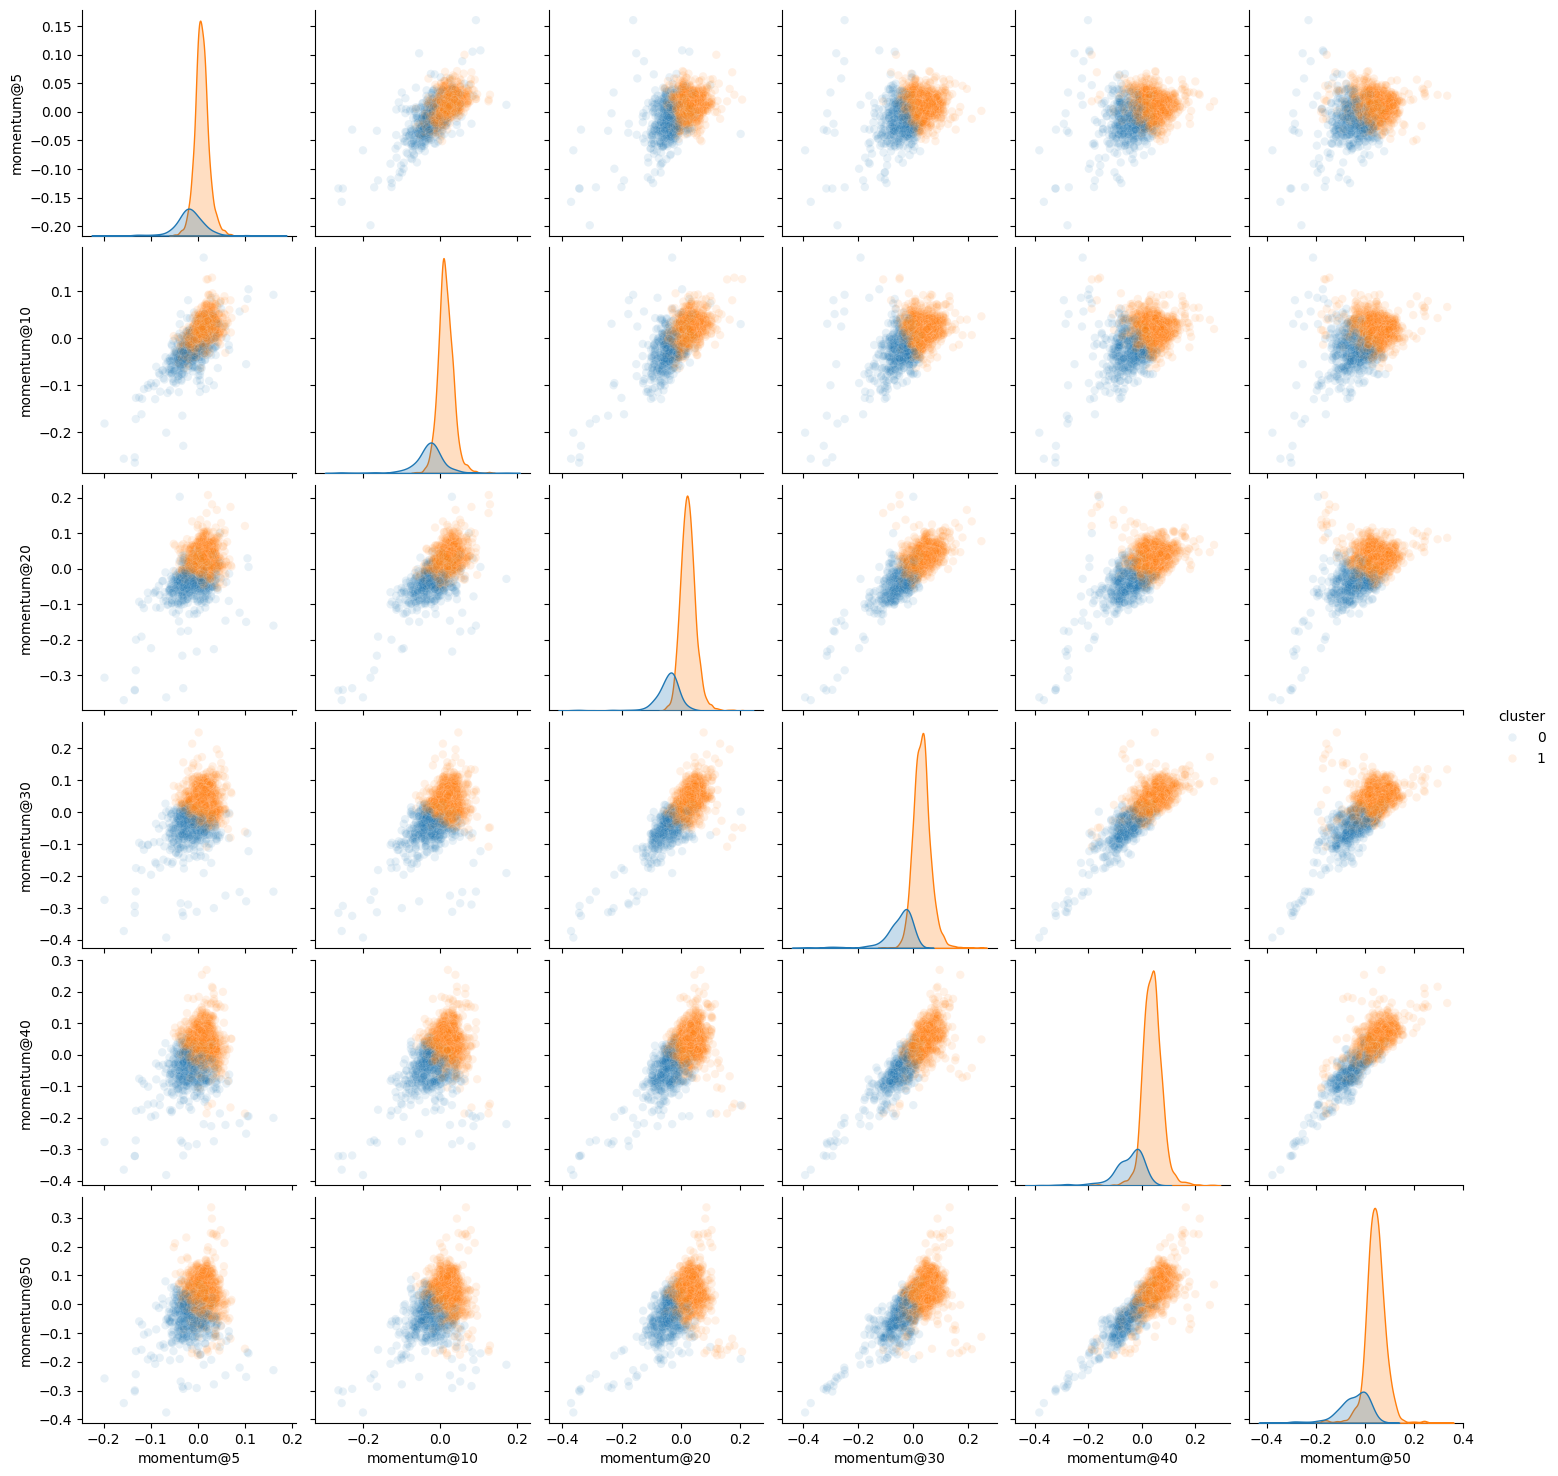

In [ ]:
sns.pairplot(df_clusters, hue="cluster", kind='scatter', plot_kws={'alpha':0.1})
plt.show()

Intentemos ahora analizar un valor de K mayor.

In [ ]:
n_clusters = 15 # Pon múltiplos de 3 para dibujar los patrones bien
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset)
clusters = kmeans.predict(dataset)

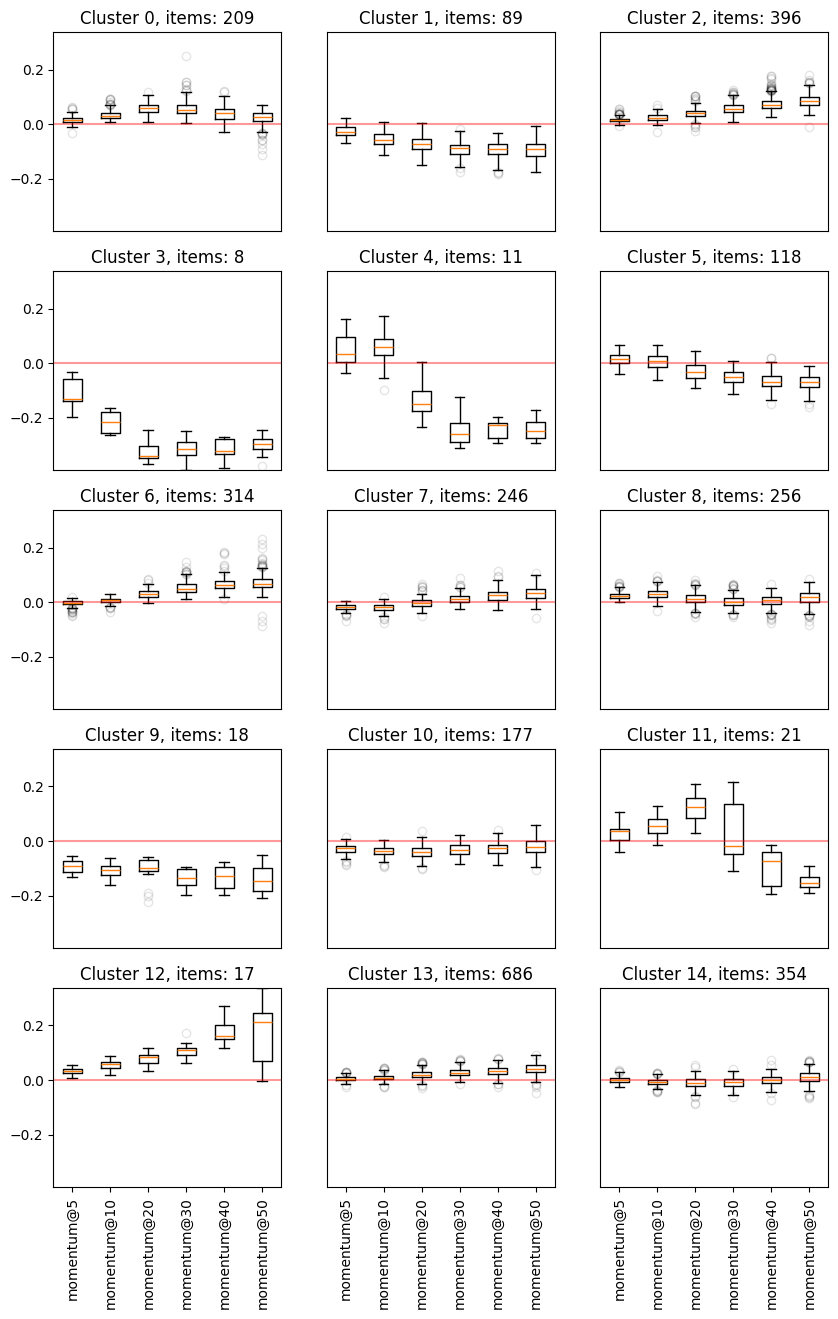

In [ ]:
filas = n_clusters // 3
columnas = n_clusters // filas
plt.figure(figsize=(10, 3*filas))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = atributos[indices]
    plt.subplot(filas, columnas, c+1)
    plt.boxplot(datos, flierprops={"alpha":0.1})
    plt.ylim(atributos.min().min(), atributos.max().max())
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.axhline(0.0, color="red", alpha=0.4)
    if c % columnas != 0:
        plt.yticks([])
    if c // columnas < filas-1:
        plt.xticks([])
    else:
        plt.xticks(range(1, dataset.shape[1]+1), lista_atributos, rotation=90)
plt.show()

Otra forma de visualizar estos clusters consiste en representar su comportamiento gráfico a lo largo del tiempo. Cada cluster marca una tendencia de comportamiento a 50 días hacia atrás.

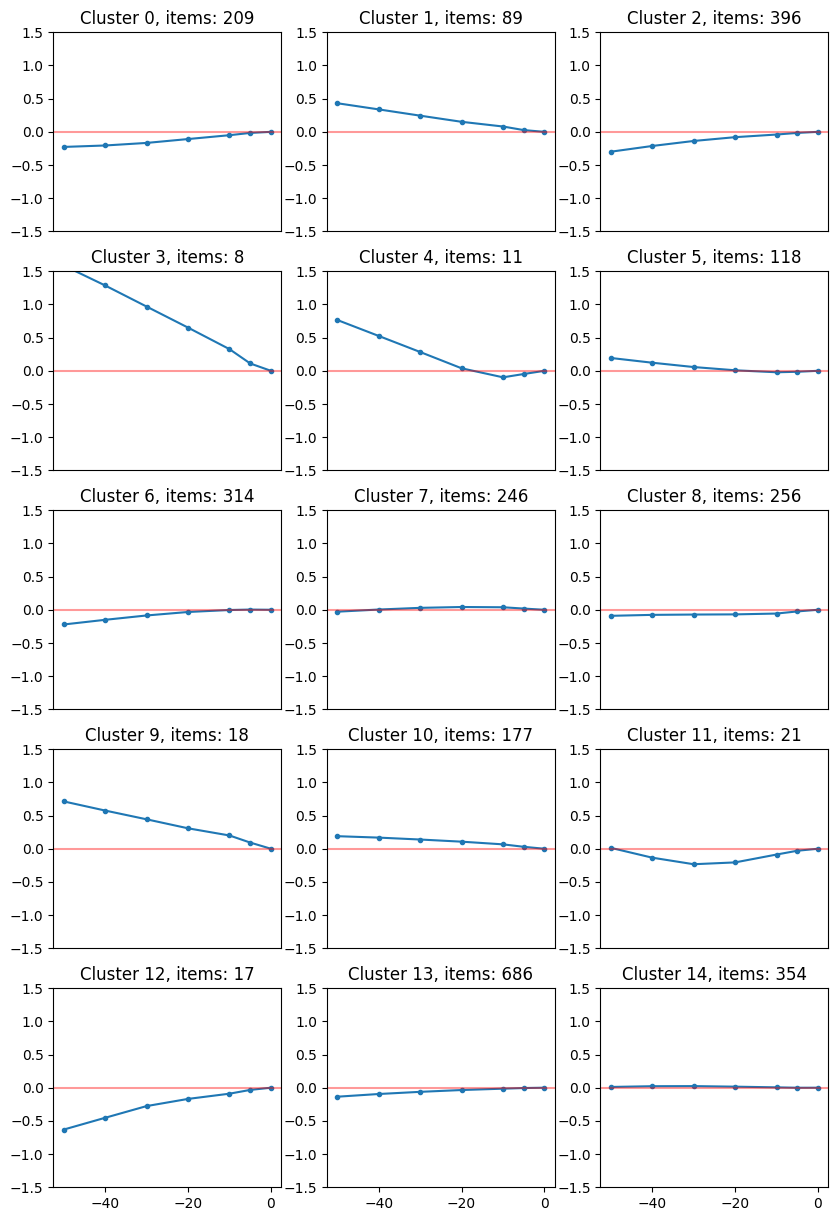

In [ ]:
times = np.array(momentum_values[::-1] + [0]) * -1

filas = n_clusters // 3
columnas = n_clusters // filas
plt.figure(figsize=(10, 3*filas))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = atributos[indices]
    plt.subplot(filas, columnas, c+1)
    medias = list(-((datos.mean()).cumsum())[::-1])
    plt.plot(times, medias + [0], '.-')
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.ylim(-1.5, 1.5)
    if c // columnas < filas-1:
        plt.xticks([])
    plt.axhline(0.0, color="red", alpha=0.4)
plt.show()

**Pregunta** ¿Qué conclusiones podemos sacar de este resultado?

Visualicemos de nuevo con los clusters formados analizando los centroides.

In [ ]:
df_clusters = pd.concat([atributos, pd.Series(clusters, name='cluster', index=dataset.index)], axis=1)
df_clusters.sample(5)

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50,cluster
2014-01-31 00:00:00,-0.003977,-0.034422,-0.026255,0.002780,-0.003359,-0.001521,14
2023-10-03 00:00:00,-0.010124,-0.048882,-0.060003,-0.037719,-0.063270,-0.070983,10
2022-02-28 00:00:00,0.005512,-0.008734,-0.012111,-0.061940,-0.086668,-0.071415,5
2018-02-20 00:00:00,0.022581,0.027910,-0.040757,-0.007416,0.016232,0.035626,8
2021-09-02 00:00:00,0.015410,0.029855,0.025545,0.039908,0.050389,0.069885,2


In [ ]:
df_clusters.groupby("cluster").mean()

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50
cluster,,,,,,
0,0.016261,0.034188,0.058054,0.058410,0.038486,0.021826
1,-0.026514,-0.053828,-0.070991,-0.092539,-0.094430,-0.092836
2,0.016127,0.024340,0.039724,0.057297,0.075441,0.086411
3,-0.110776,-0.215510,-0.324504,-0.317079,-0.317783,-0.300433
4,0.048224,0.049838,-0.136200,-0.245421,-0.241839,-0.240489
5,0.014532,0.007404,-0.029962,-0.048827,-0.065241,-0.071358
6,-0.003080,0.006570,0.029848,0.052396,0.065420,0.070391
7,-0.018184,-0.019673,-0.003885,0.012617,0.025446,0.032575
8,0.024905,0.032045,0.012384,0.002546,0.004828,0.014333


**¿Podemos intentar explicar cada cluster?**

## Clustering de activos con Momentum y Riesgo

Vamos a hacer lo mismo pero incorporando una nueva variable. El riesgo calculado como la desviación típica para cada ventana.

In [ ]:
TICKER = "IDX" # SP500
momentum_values = [5, 10, 20, 30, 40, 50]
lista_atributos = ["momentum@"+str(m) for m in momentum_values] + ["risk@"+str(m) for m in momentum_values]

In [ ]:
atributos = pd.DataFrame()
for m in momentum_values:
  atributos = pd.concat((atributos, retornos[TICKER].rolling(m).sum()), axis=1)

for m in momentum_values:
  atributos = pd.concat((atributos, retornos[TICKER].rolling(m).std()), axis=1)

atributos.columns = lista_atributos
atributos = atributos.dropna()
atributos

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50,risk@5,risk@10,risk@20,risk@30,risk@40,risk@50
2013-03-15 00:00:00,0.006943,0.028599,0.027417,0.044570,0.062431,0.069186,0.003228,0.003342,0.007532,0.006998,0.006277,0.005801
2013-03-18 00:00:00,-0.002379,0.017755,0.023066,0.028802,0.050457,0.065914,0.004076,0.004126,0.007672,0.006910,0.006324,0.005861
2013-03-19 00:00:00,-0.002459,0.006510,0.013273,0.037780,0.045904,0.059206,0.004085,0.003438,0.007559,0.006545,0.006347,0.005866
2013-03-20 00:00:00,0.003090,0.012111,0.032776,0.034695,0.047487,0.068904,0.005304,0.003980,0.007004,0.006426,0.006379,0.005894
2013-03-21 00:00:00,-0.010799,0.001721,0.030294,0.025387,0.037299,0.063205,0.005842,0.005025,0.007168,0.006667,0.006563,0.006031
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14 00:00:00,0.028680,0.018238,0.040516,0.039025,0.055787,0.095178,0.004382,0.007125,0.006322,0.008026,0.007598,0.009327
2024-10-15 00:00:00,0.011466,0.019436,0.032307,0.052018,0.038471,0.116934,0.006842,0.006930,0.006688,0.007088,0.007617,0.008278
2024-10-16 00:00:00,0.008901,0.023351,0.039615,0.058404,0.044436,0.112093,0.006497,0.006945,0.006624,0.007066,0.007623,0.008224
2024-10-17 00:00:00,0.010738,0.025267,0.022780,0.060925,0.041091,0.118886,0.006296,0.006843,0.005619,0.007027,0.007615,0.008129


In [ ]:
means_train = atributos.mean()
stds_train = atributos.std()
dataset = (atributos - means_train) / stds_train

Voy a probar con `K = 5`, por ejemplo.

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset) # Utilizamos clustering con los datos normalizados!!!
clusters = kmeans.predict(dataset)

In [ ]:
df_clusters = pd.concat([atributos, pd.Series(clusters, name='cluster', index=dataset.index)], axis=1)
df_clusters.groupby("cluster").mean()

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50,risk@5,risk@10,risk@20,risk@30,risk@40,risk@50
cluster,,,,,,,,,,,,
0,0.003771,0.008701,0.019309,0.029591,0.038776,0.046238,0.005647,0.005850,0.006120,0.006356,0.006594,0.006809
1,-0.018428,-0.030722,-0.042603,-0.046076,-0.045316,-0.040543,0.014719,0.014211,0.013388,0.012729,0.012256,0.011862
2,-0.038799,-0.079337,-0.221102,-0.262793,-0.258151,-0.249571,0.055750,0.055407,0.051016,0.043143,0.037710,0.033943
3,0.020958,0.042287,0.095311,0.069824,-0.031466,-0.122249,0.019372,0.021520,0.028042,0.036801,0.041490,0.041336
4,0.017643,0.026052,0.031365,0.030120,0.031099,0.033943,0.009861,0.011173,0.012079,0.012458,0.012573,0.012729


**¿Cómo interpretamos cada cluster?**

Intentemos visualizar el comportamiento:

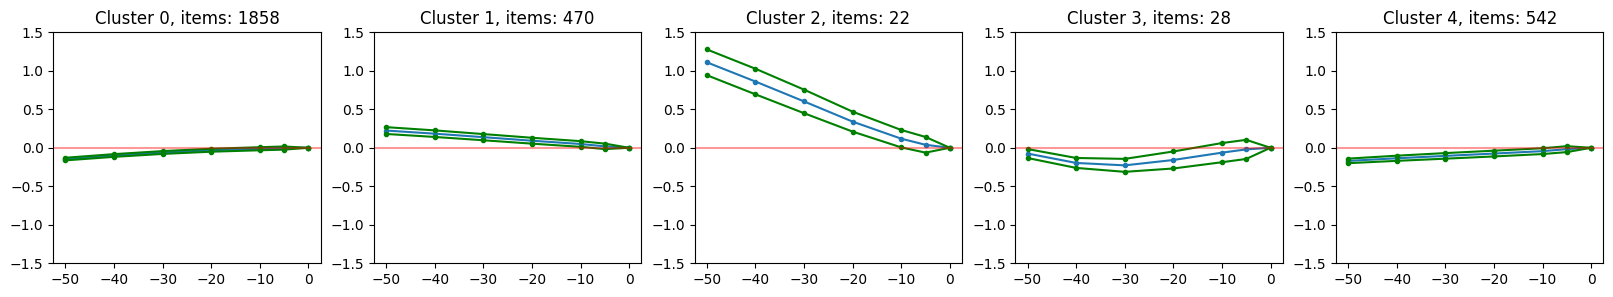

In [ ]:
times = np.array(momentum_values[::-1] + [0]) * -1

filas = 1
columnas = n_clusters
plt.figure(figsize=(20, 3*filas))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = atributos[indices]
    plt.subplot(filas, columnas, c+1)
    medias = (-((datos.mean()[:len(momentum_values)]).cumsum())[::-1])
    stds = ((datos.mean()[len(momentum_values):])).values
    p25 = medias - 3 * stds
    p75 = medias + 3 * stds
    plt.plot(times, list(medias) + [0], '.-')
    plt.plot(times, list(p25) + [0], '.-', color="green")
    plt.plot(times, list(p75) + [0], '.-', color="green")
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.ylim(-1.5, 1.5)
    if c // columnas < filas-1:
        plt.xticks([])
    plt.axhline(0.0, color="red", alpha=0.4)
plt.show()

## ¿Y si intentamos ver la probabilidad de transición entre clusters?

Viendo el `head()` se puede explicar fácilmente cómo vamos a comprobar esto.

In [ ]:
df_clusters.head()

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50,risk@5,risk@10,risk@20,risk@30,risk@40,risk@50,cluster
2013-03-15 00:00:00,0.006943,0.028599,0.027417,0.044570,0.062431,0.069186,0.003228,0.003342,0.007532,0.006998,0.006277,0.005801,0
2013-03-18 00:00:00,-0.002379,0.017755,0.023066,0.028802,0.050457,0.065914,0.004076,0.004126,0.007672,0.006910,0.006324,0.005861,0
2013-03-19 00:00:00,-0.002459,0.006510,0.013273,0.037780,0.045904,0.059206,0.004085,0.003438,0.007559,0.006545,0.006347,0.005866,0
2013-03-20 00:00:00,0.003090,0.012111,0.032776,0.034695,0.047487,0.068904,0.005304,0.003980,0.007004,0.006426,0.006379,0.005894,0
2013-03-21 00:00:00,-0.010799,0.001721,0.030294,0.025387,0.037299,0.063205,0.005842,0.005025,0.007168,0.006667,0.006563,0.006031,0


1. Definimos una matriz de transiciones entre clusters.

In [ ]:
m = np.zeros((n_clusters, n_clusters))
m

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

2. Contamos cuantas veces ocurre la transición $c_{t-1} \rightarrow c_t$.

In [ ]:
for i in range(len(df_clusters)-1):
  cprev = df_clusters["cluster"].iloc[i]
  cnext = df_clusters["cluster"].iloc[i+1]
  m[cprev, cnext] += 1 # Sumamos en la transicion
m

array([[1.798e+03, 4.000e+01, 0.000e+00, 0.000e+00, 1.900e+01],
       [2.200e+01, 3.910e+02, 1.000e+00, 0.000e+00, 5.600e+01],
       [0.000e+00, 0.000e+00, 2.100e+01, 1.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 2.700e+01, 1.000e+00],
       [3.700e+01, 3.900e+01, 0.000e+00, 0.000e+00, 4.660e+02]])

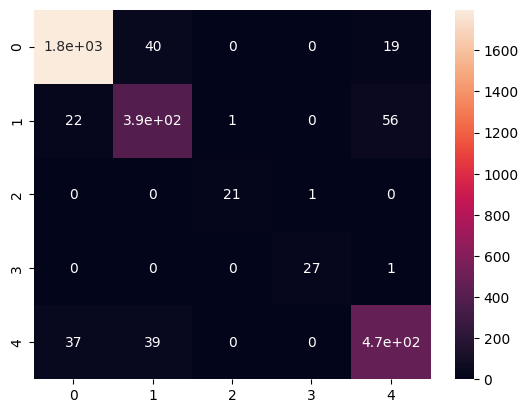

In [ ]:
sns.heatmap(m, annot=True)
plt.show()

3. Por supuesto, esto **NO son probabilidades**, por tanto normalizamos por filas.

In [ ]:
probs = m / m.sum(axis=1, keepdims=True)
probs

array([[0.96822833, 0.02154012, 0.        , 0.        , 0.01023156],
       [0.04680851, 0.83191489, 0.00212766, 0.        , 0.11914894],
       [0.        , 0.        , 0.95454545, 0.04545455, 0.        ],
       [0.        , 0.        , 0.        , 0.96428571, 0.03571429],
       [0.06826568, 0.07195572, 0.        , 0.        , 0.8597786 ]])

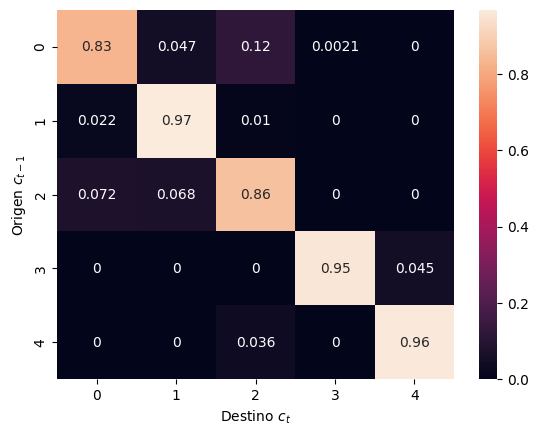

In [ ]:
sns.heatmap(probs, annot=True)
plt.xlabel("Destino $c_t$")
plt.ylabel("Origen $c_{t-1}$")
plt.show()

4. Pintamos la máquina de estados probabilística con estas transiciones.

In [ ]:
from graphviz import Digraph

def pinta_automata(matriz_transiciones, clusters, cluster_names, decimals=2):
  dot = Digraph(format='png')
  dot.attr(rankdir='LR')  # dirección izquierda a derecha
  dot.attr('node', shape='circle')

  for c, c_name in zip(clusters, cluster_names):
    dot.node(str(c), label=str(c_name))

  for i in range(len(matriz_transiciones)):
    for j in range(len(matriz_transiciones)):
      prob = np.around(matriz_transiciones[i, j], decimals=decimals)
      if prob > 0:
        dot.edge(str(i), str(j), label=str(prob))

  return dot

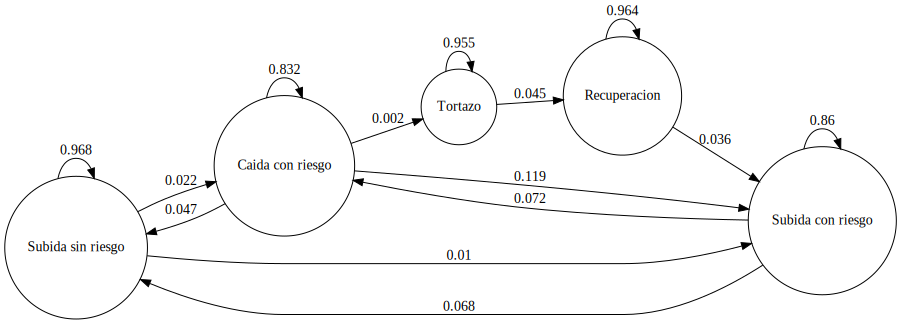

In [ ]:
clusters = [i for i in range(n_clusters)]
cluster_names = [str(i) for i in range(n_clusters)]
cluster_names = ["Subida sin riesgo",
                 "Caida con riesgo",
                 "Tortazo",
                 "Recuperacion",
                 "Subida con riesgo"]
pinta_automata(probs, clusters, cluster_names, decimals=3)

5. Extraemos la probabilidad de estar en cada cluster según la inversa de la distancia cuadrática.

In [ ]:
clusters = kmeans.predict(dataset)
df_clusters_norm = pd.concat([dataset, pd.Series(clusters, name='cluster', index=dataset.index)], axis=1)

In [ ]:
# Calculo la distancia cuadrática entre cada fila del dataset y los centroides
dist = np.mean((df_clusters_norm.groupby("cluster").mean().values[None, :, :] - dataset.values[:, None, :])**2, axis=-1)
dist.shape

(2920, 5)

In [ ]:
# Comprobación de las distancias
(clusters == np.argmin(dist, axis=1)).all()

np.True_

In [ ]:
# Quiero mayor probabilidad a menor distancia
probs_distancias = 1 / dist

# Normalizo las probabilidades para que sumen 1
probs_distancias = probs_distancias / probs_distancias.sum(axis=1, keepdims=True)
probs_distancias = pd.DataFrame(probs_distancias, index=pd.to_datetime(dataset.index))
probs_distancias

,0,1,2,3,4
2013-03-15,0.822197,0.037210,0.002436,0.006757,0.131400
2013-03-18,0.907487,0.022168,0.001230,0.003299,0.065816
2013-03-19,0.922804,0.020552,0.001084,0.002862,0.052699
2013-03-20,0.926790,0.016784,0.000959,0.002596,0.052871
2013-03-21,0.886957,0.031975,0.001554,0.004085,0.075430
...,...,...,...,...,...
2024-10-14,0.610703,0.059938,0.004094,0.012103,0.313161
2024-10-15,0.692228,0.055326,0.003536,0.010038,0.238871
2024-10-16,0.687113,0.054772,0.003631,0.010475,0.244009
2024-10-17,0.688972,0.058834,0.003928,0.011092,0.237174


Podemos comprobar el comportamiento del SP500 según las probabilidades de cada cluster. En esta primera imagen representamos todo el dataset, aunque es cierto que no queda muy claro lo que estamos viendo.

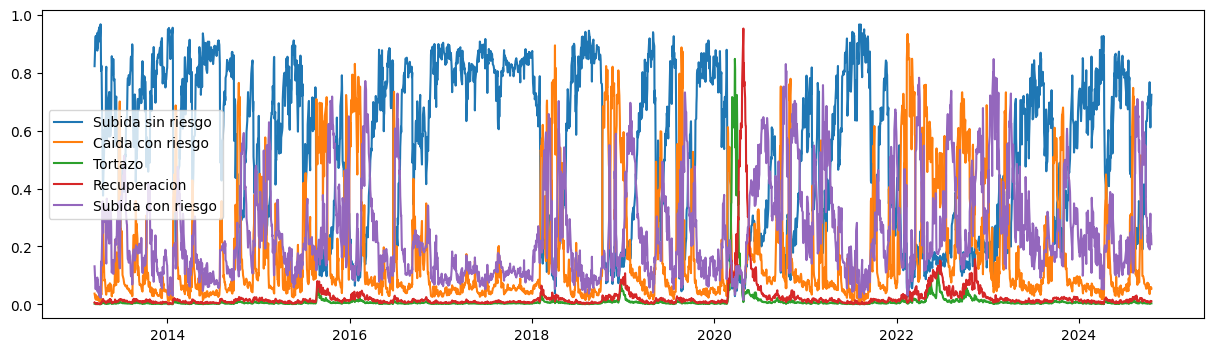

In [ ]:
plt.figure(figsize=(15, 4))
for c, cname in enumerate(cluster_names):
  plt.plot(probs_distancias[c], label=cname)
plt.legend()
plt.show()

Sin embargo, podemos analizar ventanas específicas. Por ejemplo, analicemos el COVID desde enero de 2020 hasta junio de 2020.

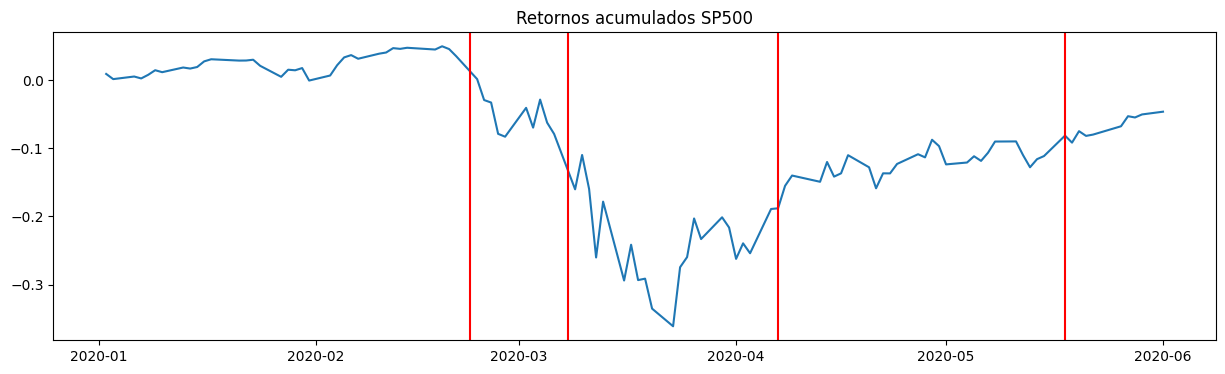

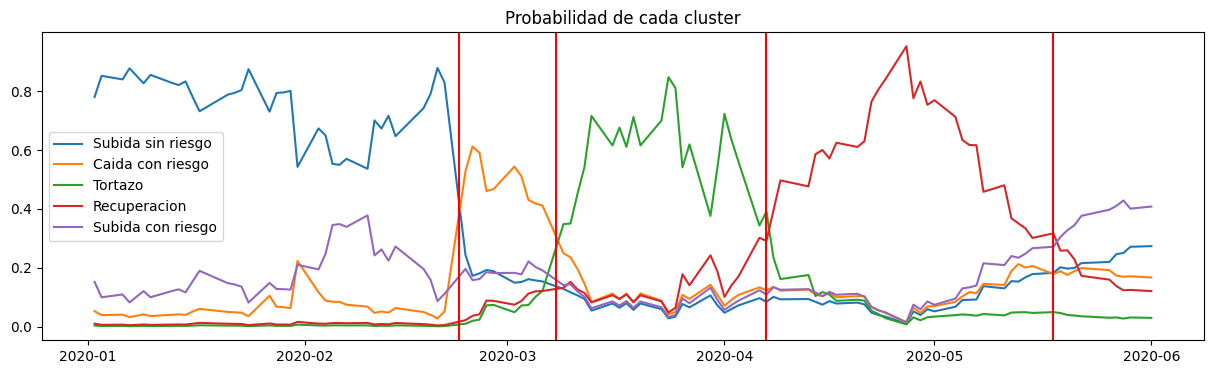

In [ ]:
start_date = "2020-01-01"
end_date = "2020-06-01"
plt.figure(figsize=(15, 4))
plt.title("Retornos acumulados SP500")
plt.plot(np.cumsum(retornos[start_date:end_date]["IDX"]))

# ETIQUETAS PUESTAS A OJO
plt.axvline(pd.to_datetime("2020-02-23"), color="red")
plt.axvline(pd.to_datetime("2020-03-08"), color="red")
plt.axvline(pd.to_datetime("2020-04-07"), color="red")
plt.axvline(pd.to_datetime("2020-05-18"), color="red")
plt.show()


plt.figure(figsize=(15, 4))
plt.title("Probabilidad de cada cluster")
for c, cname in enumerate(cluster_names):
  plt.plot(probs_distancias[start_date:end_date][c], label=cname)

# ETIQUETAS PUESTAS A OJO
plt.axvline(pd.to_datetime("2020-02-23"), color="red")
plt.axvline(pd.to_datetime("2020-03-08"), color="red")
plt.axvline(pd.to_datetime("2020-04-07"), color="red")
plt.axvline(pd.to_datetime("2020-05-18"), color="red")
plt.legend()
plt.show()

Veamos otra ventana, por ejemplo a partir de diciembre de 2021 durante 1 año.

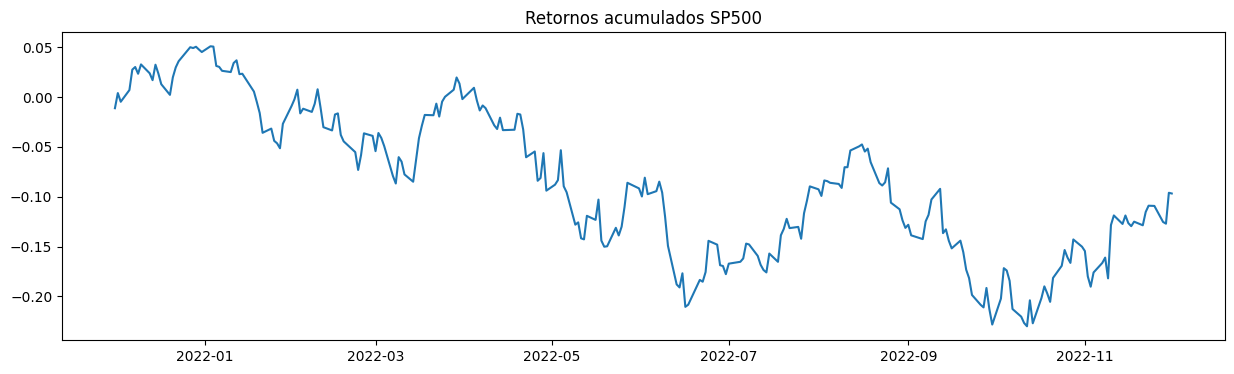

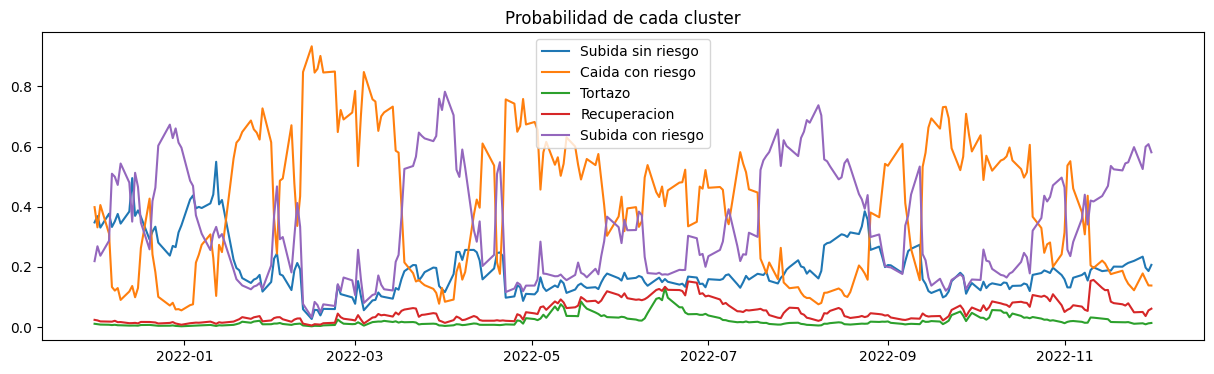

In [ ]:
start_date = "2021-12-01"
end_date = "2022-12-01"
plt.figure(figsize=(15, 4))
plt.title("Retornos acumulados SP500")
plt.plot(np.cumsum(retornos[start_date:end_date]["IDX"]))
plt.show()
plt.figure(figsize=(15, 4))
plt.title("Probabilidad de cada cluster")
for c, cname in enumerate(cluster_names):
  plt.plot(probs_distancias[start_date:end_date][c], label=cname)
plt.legend()
plt.show()

**¿Qué conclusiones podemos sacar?**

**¿Y si añadimos más atributos al clustering?**

## ¿Y si intentamos definir un activo a partir de la frecuencia de veces que está en un cluster?

Si tenemos un algoritmo de clustering entrenado, como KMeans, una idea que se nos podría ocurrir es la siguiente: **¿puedo contar en un activo determinado cuántas veces aparezco en cada cluster a lo largo del tiempo?** Y si puedo hacerlo, **¿podría decir que la frecuencia de aparición en estos clusters define también el comportamiento de mi activo en toda su existencia?**

Probemos estas cosas con `TSLA`, un activo que no hemos utilizado en el conjunto de activos para hacer clustering.

In [ ]:
TICKER = "TSLA"

In [ ]:
atributos_test = pd.DataFrame()
for m in momentum_values:
  atributos_test = pd.concat((atributos_test, retornos[TICKER].rolling(m).sum()), axis=1)

for m in momentum_values:
  atributos_test = pd.concat((atributos_test, retornos[TICKER].rolling(m).std()), axis=1)

atributos_test.columns = lista_atributos
atributos_test = atributos_test.dropna()
atributos_test

,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50,risk@5,risk@10,risk@20,risk@30,risk@40,risk@50
2013-03-15 00:00:00,-0.086279,0.018302,-0.081066,-0.061008,0.034303,-0.001981,0.030891,0.029583,0.035883,0.030583,0.027663,0.025363
2013-03-18 00:00:00,-0.106498,-0.012159,-0.052374,-0.085825,0.022149,0.010869,0.026407,0.028302,0.035246,0.030277,0.027647,0.025255
2013-03-19 00:00:00,-0.109003,-0.043782,-0.113084,-0.073089,0.016093,0.019575,0.025909,0.026158,0.032166,0.030194,0.027644,0.025208
2013-03-20 00:00:00,-0.080920,-0.047266,-0.069567,-0.058872,0.021367,0.045818,0.032936,0.025699,0.032682,0.030511,0.027749,0.025435
2013-03-21 00:00:00,-0.023059,-0.059824,0.023888,-0.084114,0.000278,0.066893,0.024431,0.024966,0.025220,0.030031,0.027515,0.025265
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14 00:00:00,-0.094289,-0.177129,-0.034178,0.023312,0.013968,0.053852,0.042519,0.035569,0.035199,0.036511,0.035163,0.035321
2024-10-15 00:00:00,-0.107544,-0.161366,-0.037104,0.041710,-0.014244,0.098969,0.040222,0.036103,0.035177,0.036364,0.034833,0.034737
2024-10-16 00:00:00,-0.085350,-0.117878,-0.026176,0.008713,0.001040,0.098143,0.042395,0.036130,0.035244,0.035617,0.034839,0.034734
2024-10-17 00:00:00,-0.077836,-0.085720,-0.099175,-0.041153,-0.010717,0.141420,0.042861,0.035341,0.030869,0.034464,0.034804,0.034066


In [ ]:
dataset_test = (atributos_test - means_train) / stds_train

In [ ]:
clusters_test = kmeans.predict(dataset_test) # Utilizo el mismo KMeans que antes

In [ ]:
# Contemos cuántas veces el Kmeans agrupa el activo en cada cluster a lo largo del tiempo
vector = np.zeros(n_clusters)
for c in clusters_test:
    vector[c] += 1

# Deberíamos normalizar el vector para compararlo con otros activos. No es necesario ahora
# vector = vector / vector.sum()

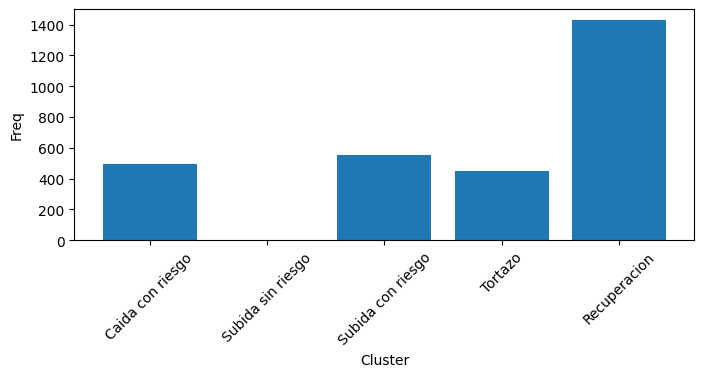

In [ ]:
plt.figure(figsize=(8, 3))
plt.bar(range(n_clusters), vector)
plt.xticks(range(n_clusters), cluster_names, rotation=45)
plt.xlabel("Cluster")
plt.ylabel("Freq")
plt.show()

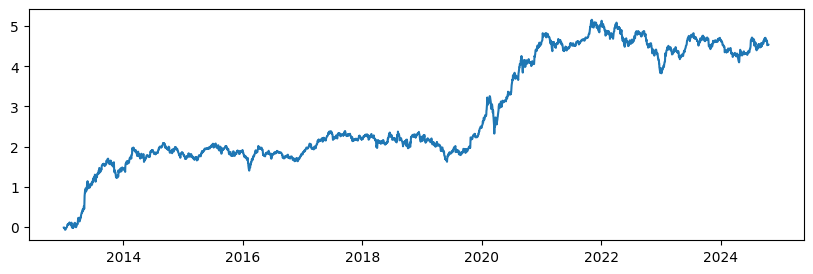

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(np.cumsum(retornos[TICKER]))
plt.show()

**Discusión**: ¿Qué podemos deducir de estas figuras?

Agrupemos todo en una función para poder comparar distintos activos. Por ejemplo, el vector de `TSLA` con `AAPL`.

In [ ]:
def build_vector(ticker):
  atributos_test = pd.DataFrame()
  for m in momentum_values:
    atributos_test = pd.concat((atributos_test, retornos[ticker].rolling(m).sum()), axis=1)

  for m in momentum_values:
    atributos_test = pd.concat((atributos_test, retornos[ticker].rolling(m).std()), axis=1)

  atributos_test.columns = lista_atributos
  atributos_test = atributos_test.dropna()

  dataset_test = (atributos_test - means_train) / stds_train
  clusters_test = kmeans.predict(dataset_test)
  # Contemos cuántas veces el Kmeans agrupa el activo en cada cluster a lo largo del tiempo
  vector = np.zeros(n_clusters)
  for c in clusters_test:
      vector[c] += 1

  vector = vector / vector.sum()

  return vector

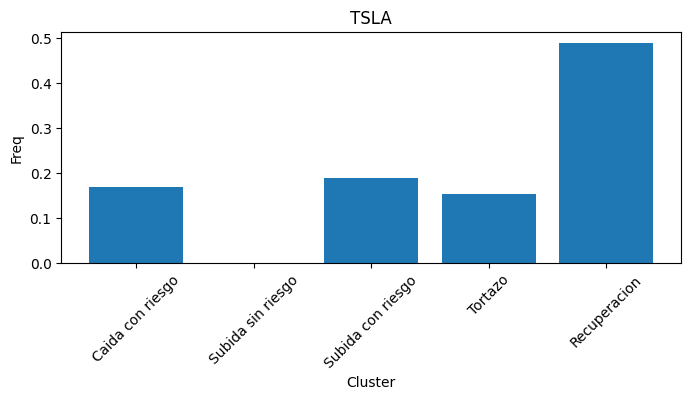

In [ ]:
TICKER = "TSLA"

plt.figure(figsize=(8, 3))
plt.bar(range(n_clusters), build_vector(TICKER))
plt.title(TICKER)
plt.xticks(range(n_clusters), cluster_names, rotation=45)
plt.xlabel("Cluster")
plt.ylabel("Freq")
plt.show()

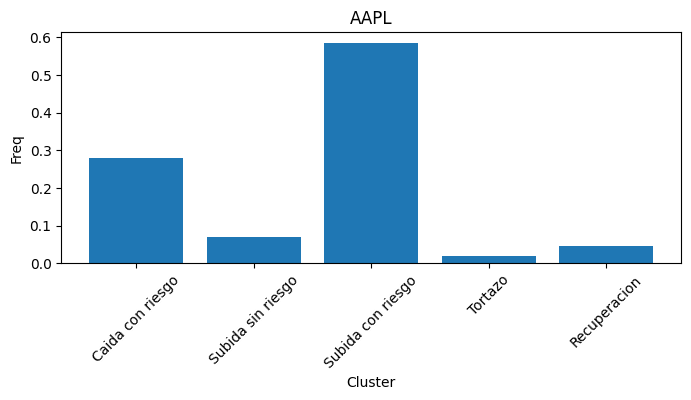

In [ ]:
TICKER = "AAPL"

plt.figure(figsize=(8, 3))
plt.bar(range(n_clusters), build_vector(TICKER))
plt.title(TICKER)
plt.xticks(range(n_clusters), cluster_names, rotation=45)
plt.xlabel("Cluster")
plt.ylabel("Freq")
plt.show()

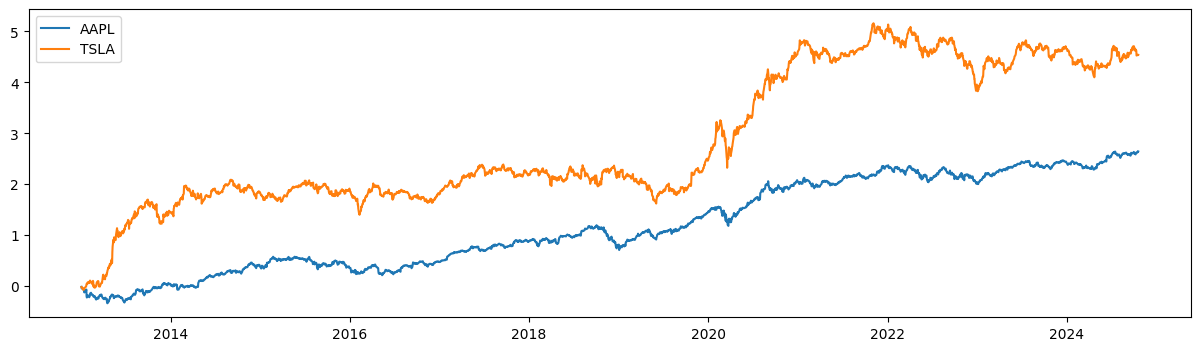

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(np.cumsum(retornos["AAPL"]), label="AAPL")
plt.plot(np.cumsum(retornos["TSLA"]), label="TSLA")
plt.legend()
plt.show()

**Discusión de los resultados**: ¿Qué podríamos hacer con estos vectores clusterizados?